# CSCI 113i Project - Predicting Hazardous Near Earth Objects

In [1]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from tuner import XGBModelTuner

In [2]:
df = pd.read_csv("datasets/Final Merged.csv", encoding='utf-8')
df.head()

,obj_id,absolute_magnitude_h,is_potentially_hazardous_asteroid,minimum_orbit_intersection,eccentricity,semi_major_axis,inclination,orbital_period,perihelion_distance,aphelion_distance,scaled_min_diameter_km,scaled_max_diameter_km,avg_diameter_km,relative_velocity.kilometers_per_hour,miss_distance.kilometers,earth_orbit_crossing_potential,orbit_stability,data_arc_in_days_scaled
0,2003200,0.066725,1,0.124112,0.459195,0.350637,0.239752,0.281288,0.731149,0.296735,0.059698,0.059698,0.059698,0.355211,0.048460,0.35396,0.110093,0.000681
1,2003271,0.090602,0,0.124112,0.459195,0.350637,0.239752,0.281288,0.731149,0.296735,0.021771,0.021771,0.021771,0.144392,0.179960,0.35396,0.110093,0.000681
2,2003288,0.077082,0,0.124112,0.459195,0.350637,0.239752,0.281288,0.731149,0.296735,0.038542,0.038542,0.038542,0.068288,0.069839,0.35396,0.110093,0.000681
3,2003352,0.083951,0,0.124112,0.459195,0.350637,0.239752,0.281288,0.731149,0.296735,0.028834,0.028834,0.028834,0.134361,0.119942,0.35396,0.110093,0.000681
4,2003360,0.084714,0,0.124112,0.459195,0.350637,0.239752,0.281288,0.731149,0.296735,0.027919,0.027919,0.027919,0.256131,0.075072,0.35396,0.110093,0.000681


In [3]:
df.shape

(39016, 18)

# 🛰️ Class Distribution

<Axes: title={'center': 'Class Distribution'}, xlabel='is_potentially_hazardous_asteroid', ylabel='count'>

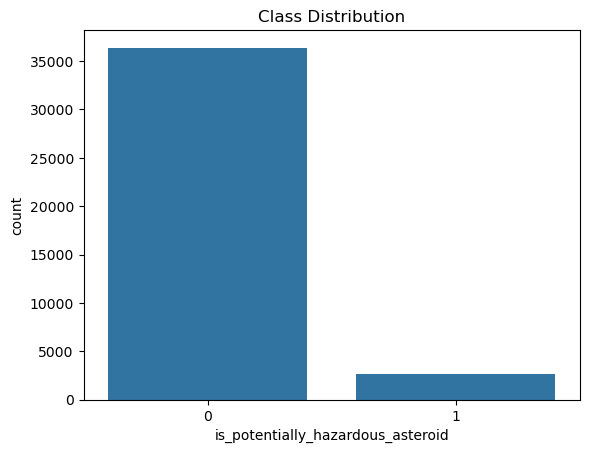

In [4]:
fig, ax = plt.subplots()
ax.set_title("Class Distribution")
sns.countplot(x='is_potentially_hazardous_asteroid', data=df)

The dataset is **heavily imbalanced**, with far fewer hazardous asteroids than non-hazardous ones. This imbalance poses a serious challenge:  
> Models may **misclassify hazardous asteroids as non-hazardous**, which is unacceptable for a high-stakes task like asteroid threat detection.

Hence, **accuracy is not a reliable metric** here. We prioritize:
- **Recall** (catching hazardous objects),
- **ROC-AUC** (overall class separability),
- and **F1-score** (balance between precision and recall).

# 🔍 Data Preparation and Correlation Analysis

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.isnull().any()

obj_id                                   False
absolute_magnitude_h                     False
is_potentially_hazardous_asteroid        False
minimum_orbit_intersection               False
eccentricity                             False
semi_major_axis                          False
inclination                              False
orbital_period                           False
perihelion_distance                      False
aphelion_distance                        False
scaled_min_diameter_km                   False
scaled_max_diameter_km                   False
avg_diameter_km                          False
relative_velocity.kilometers_per_hour    False
miss_distance.kilometers                 False
earth_orbit_crossing_potential            True
orbit_stability                          False
data_arc_in_days_scaled                  False
dtype: bool

In [6]:
df['earth_orbit_crossing_potential'] = df['earth_orbit_crossing_potential'].fillna(df['earth_orbit_crossing_potential'].median())

Text(0.5, 1.0, 'Correlation Heatmap')

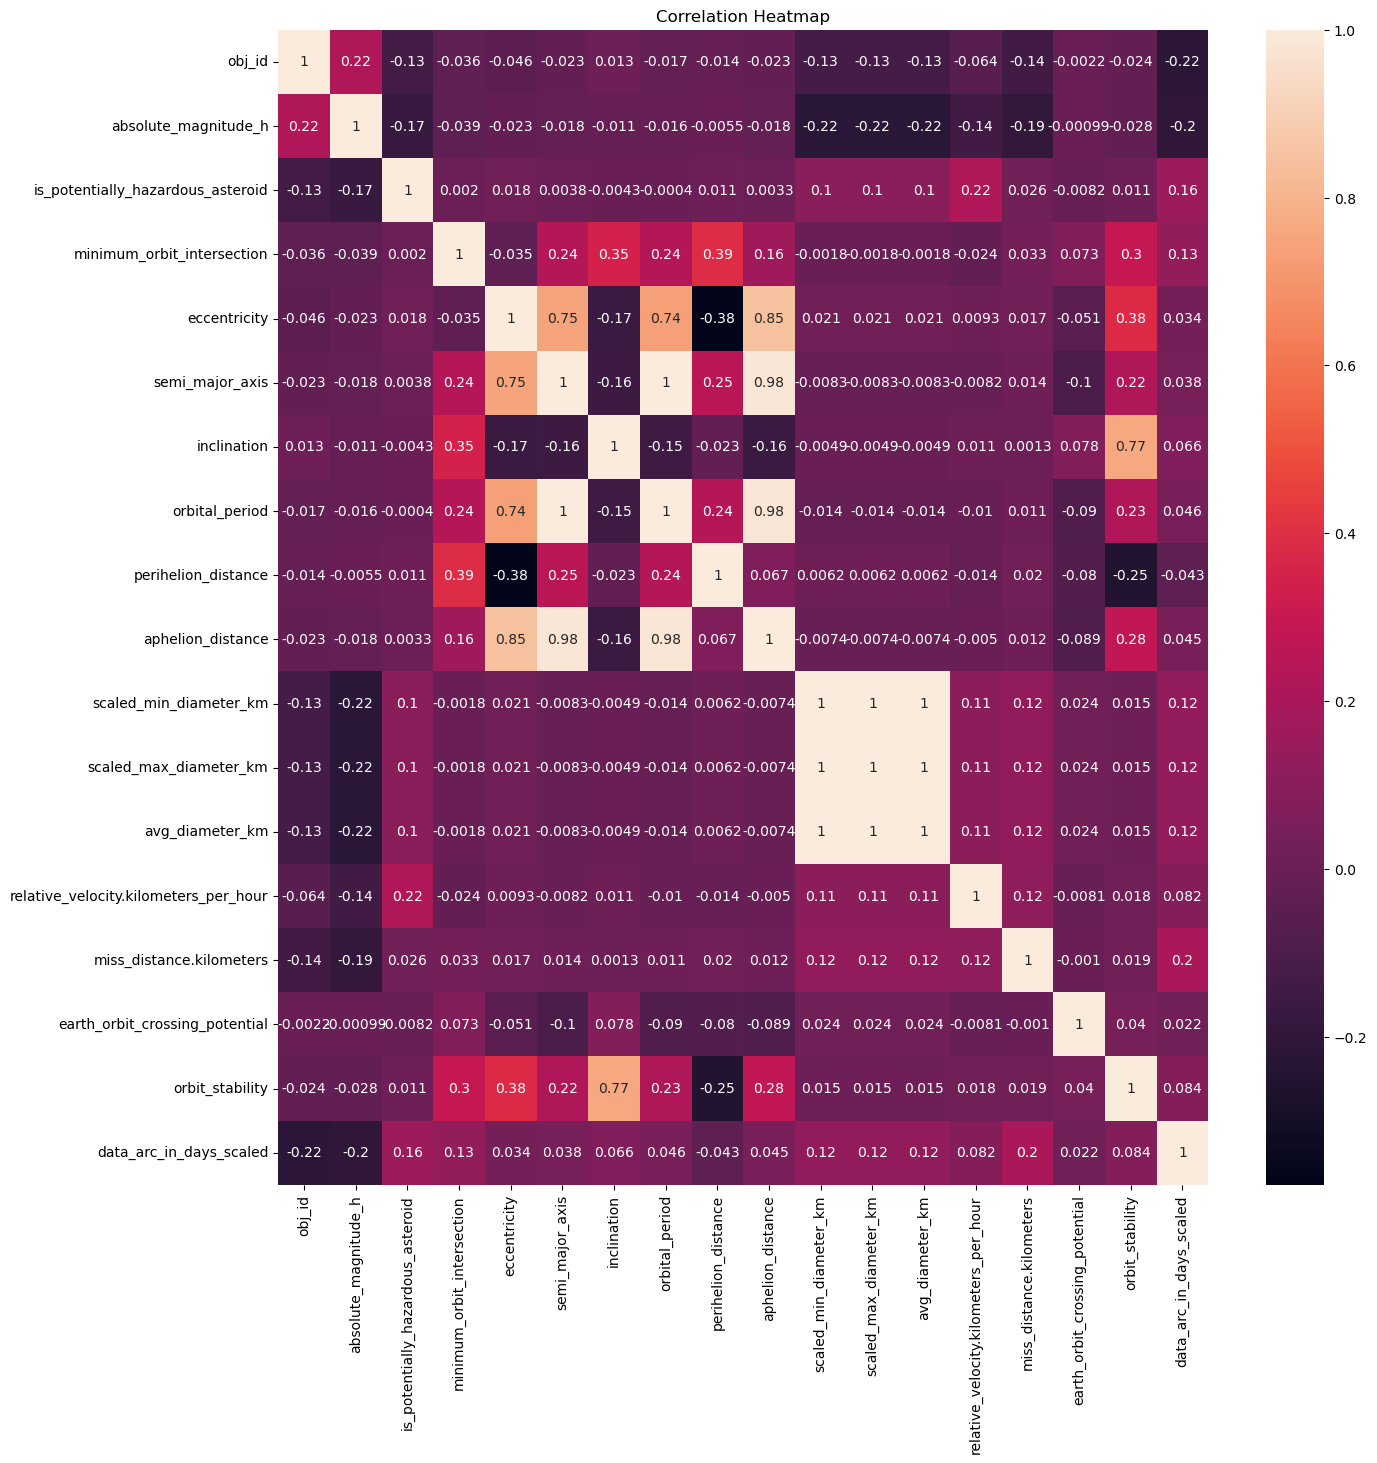

In [7]:
corr = df.corr()
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot=True, ax=ax)
ax.set_title("Correlation Heatmap")

In [8]:
corr.columns

Index(['obj_id', 'absolute_magnitude_h', 'is_potentially_hazardous_asteroid',
       'minimum_orbit_intersection', 'eccentricity', 'semi_major_axis',
       'inclination', 'orbital_period', 'perihelion_distance',
       'aphelion_distance', 'scaled_min_diameter_km', 'scaled_max_diameter_km',
       'avg_diameter_km', 'relative_velocity.kilometers_per_hour',
       'miss_distance.kilometers', 'earth_orbit_crossing_potential',
       'orbit_stability', 'data_arc_in_days_scaled'],
      dtype='object')

Text(0.5, 1.0, 'Asteroid Hazard Correlation')

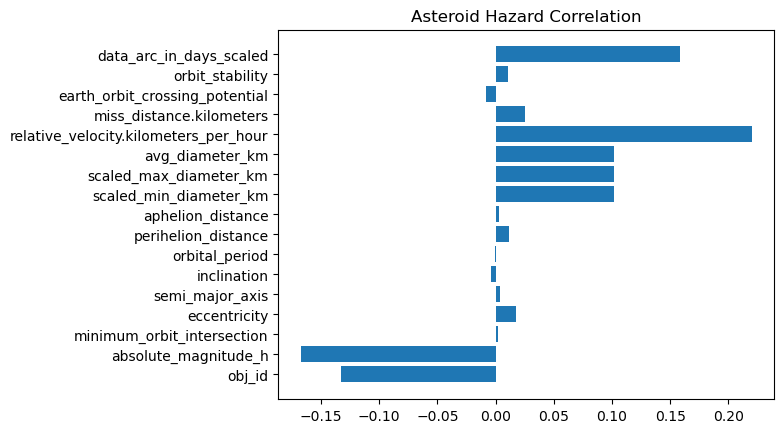

In [9]:
fig, ax = plt.subplots()
temp = corr.drop(columns=['obj_id']).drop('is_potentially_hazardous_asteroid')
ax.barh(temp.index, temp['is_potentially_hazardous_asteroid'])
ax.set_title("Asteroid Hazard Correlation")

Predictor variables show **relatively weak correlation** with the target variable. This suggests:
- No single feature strongly predicts hazardous status,
- Model performance will likely rely on **complex interactions** between features rather than linear relationships.

In [10]:
X = df.drop(columns=['obj_id', 'is_potentially_hazardous_asteroid'])
Y = df[['is_potentially_hazardous_asteroid']]

In [11]:
# from sklearn.datasets import load_wine
# data = load_wine()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 🧪 Model Training (No Oversampling)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = xgb.XGBRFClassifier(tree_method='hist', device='cpu', seed=42)

param_grid = {
    "colsample_bynode": [0.4, 0.6, 0.8],
    "subsample": [0.4, 0.6, 0.8],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

# tuner = XGBModelTuner(model, param_grid, X_train, Y_train)
# opt_model = tuner.run(save_model=True, save_params=True, cv=skf)

## 🌲 Random Forest Classifier

In [13]:
# tuner = XGBModelTuner(model, param_grid, X_train, Y_train)
# rf_model = tuner.run(save_model=True, save_params=True, cv=skf, model_path="models/random_forest.json",
#                      param_path="params/rf_params.json")
rf_model = rf_model = xgb.XGBRFClassifier()
rf_model.load_model("models/random_forest.json")

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve

def assess_model(Y_test, Y_pred, model: str, save_fig=False):
    accuracy = accuracy_score(Y_test.to_numpy(), Y_pred)
    precision = precision_score(Y_test.to_numpy(), Y_pred)
    f1 = f1_score(Y_test.to_numpy(), Y_pred)
    recall = recall_score(Y_test.to_numpy(), Y_pred)
    roc_auc_s = roc_auc_score(Y_test.to_numpy(), Y_pred)
    
    fpr, tpr, thresholds = roc_curve(Y_test.to_numpy(), Y_pred)
    
    cm = confusion_matrix(Y_test, Y_pred)
    cm = confusion_matrix(Y_test, Y_pred)
    classes = ['Not Hazardous', 'Hazardous']
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    # print(f'Accuracy: {accuracy * 100}%')
    # print(f'Precision: {precision * 100}%')
    # print(f'F1-Score: {f1}')
    # print(f'Recall: {recall}')
    # print(f'ROC AUC Score: {roc_auc_s}')

    metrics_text = (
        f"Accuracy: {accuracy * 100:.2f}%\n"
        f"Precision: {precision * 100:.2f}%\n"
        f"Recall: {recall * 100:.2f}%\n"
        f"F1-Score: {f1:.2f}\n"
        f"ROC AUC: {roc_auc_s:.2f}"
    )
    
    fig, ax = plt.subplots(figsize=(20,8), ncols=2)
    sns.heatmap(cm_df, annot=True, fmt='g', ax=ax[0])
    ax[0].set_title(f"{model} Confusion Matrix")
    
    ax[1].plot(fpr, tpr)
    ax[1].grid(True)
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title(f"{model} ROC Curve")
    ax[1].text(
        0.6, 0.3, metrics_text,
        bbox=dict(facecolor='white', alpha=0.8),
        fontsize=12, verticalalignment='top'
    )

    if save_fig:
        plt.savefig(f"{model} Assessment.png")
    
    plt.tight_layout()
    plt.show()

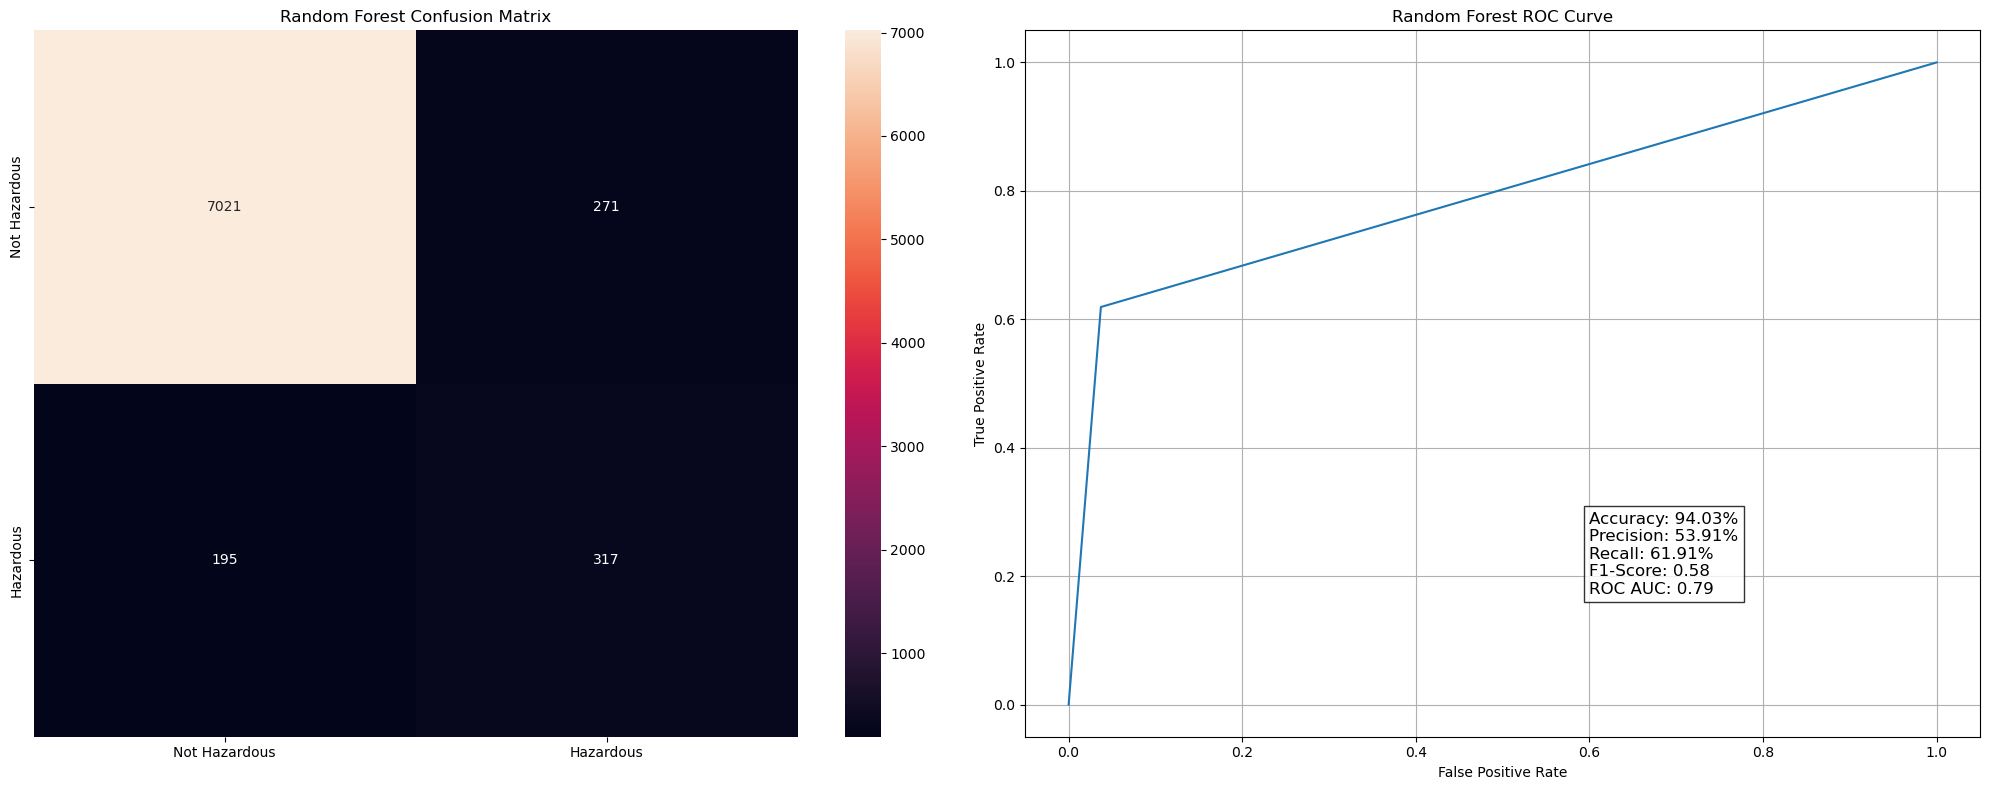

In [15]:
Y_pred = rf_model.predict(X_test)
assess_model(Y_test, Y_pred, "Random Forest", save_fig=True)

Although accuracy is high, it is **misleading** due to class imbalance.  The **recall and ROC-AUC scores** indicate **mediocre detection of hazardous asteroids** — a key weakness for this use case.

## ⚡ Gradient Boosted Classifier

In [16]:
model = xgb.XGBClassifier(tree_method='hist', device='cpu', seed=42)
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

In [17]:
# tuner = XGBModelTuner(model, param_grid, X_train, Y_train)
# gb_model = tuner.run(save_model=True, save_params=True, cv=skf, model_path="models/gradient_booster.json",
#                      param_path="params/gb_params.json")
gb_model = xgb.XGBClassifier()
gb_model.load_model("models/gradient_booster.json")

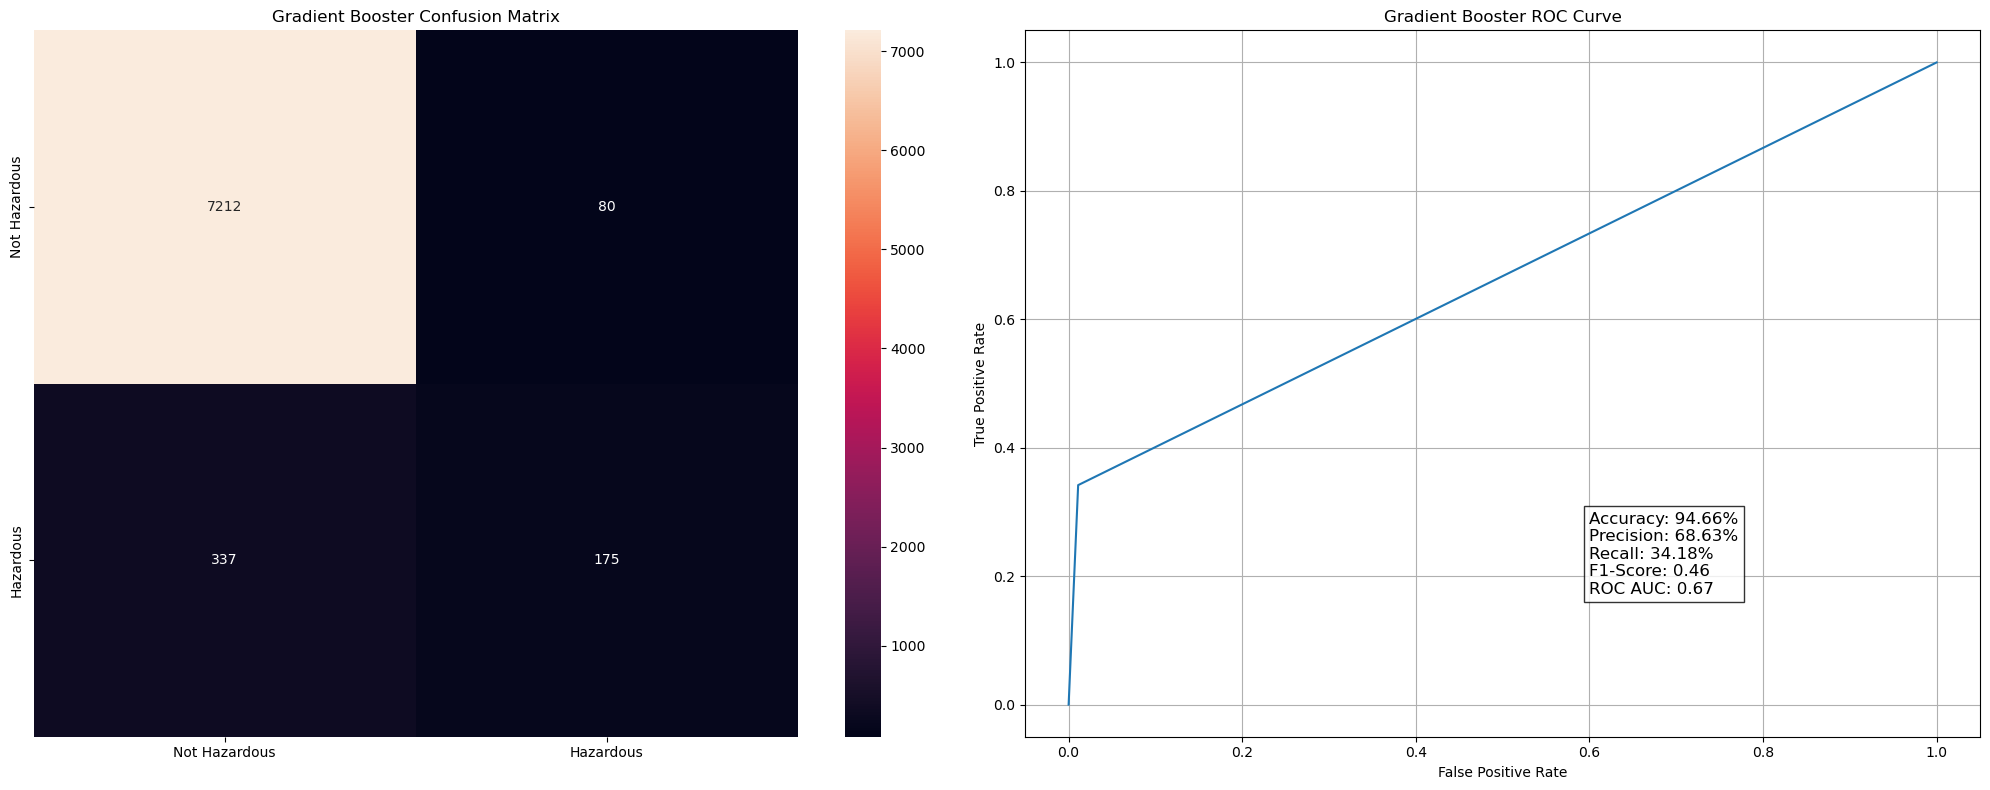

In [18]:
Y_pred = gb_model.predict(X_test)
assess_model(Y_test, Y_pred, "Gradient Booster", save_fig=True)

Despite higher **precision and accuracy**, this model performs **significantly worse** in recall and ROC-AUC. It **fails to detect hazardous objects reliably**, likely due to **overfitting** or poor generalization.

### 🛠️ Recommended Action
> Use **oversampling techniques** (e.g., SMOTE) to address the imbalance and improve model sensitivity to hazardous cases.

# 🔄 Model Training (With SMOTE Oversampling)

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_train, Y_train)

Text(0, 0.5, 'count')

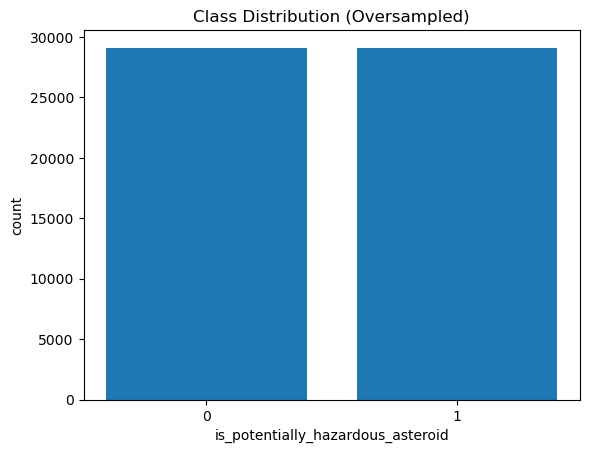

In [21]:
fig, ax = plt.subplots()
temp = Y_res.value_counts().reset_index()
ax.bar(temp['is_potentially_hazardous_asteroid'], temp['count'])
ax.set_xticks([0,1])
ax.set_title("Class Distribution (Oversampled)")
ax.set_xlabel('is_potentially_hazardous_asteroid')
ax.set_ylabel('count')

## 🌲 Random Forest Classifier (Oversampled)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = xgb.XGBRFClassifier(tree_method='hist', device='cpu', seed=42)

param_grid = {
    "colsample_bynode": [0.4, 0.6, 0.8],
    "subsample": [0.4, 0.6, 0.8],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

In [23]:
# tuner = XGBModelTuner(model, param_grid, X_res, Y_res)
# rfos_model = tuner.run(save_model=True, save_params=True, cv=skf, model_path="models/random_forest_os.json",
#                      param_path="params/rfos_params.json")

rfos_model = xgb.XGBRFClassifier()
rfos_model.load_model("models/random_forest_os.json")

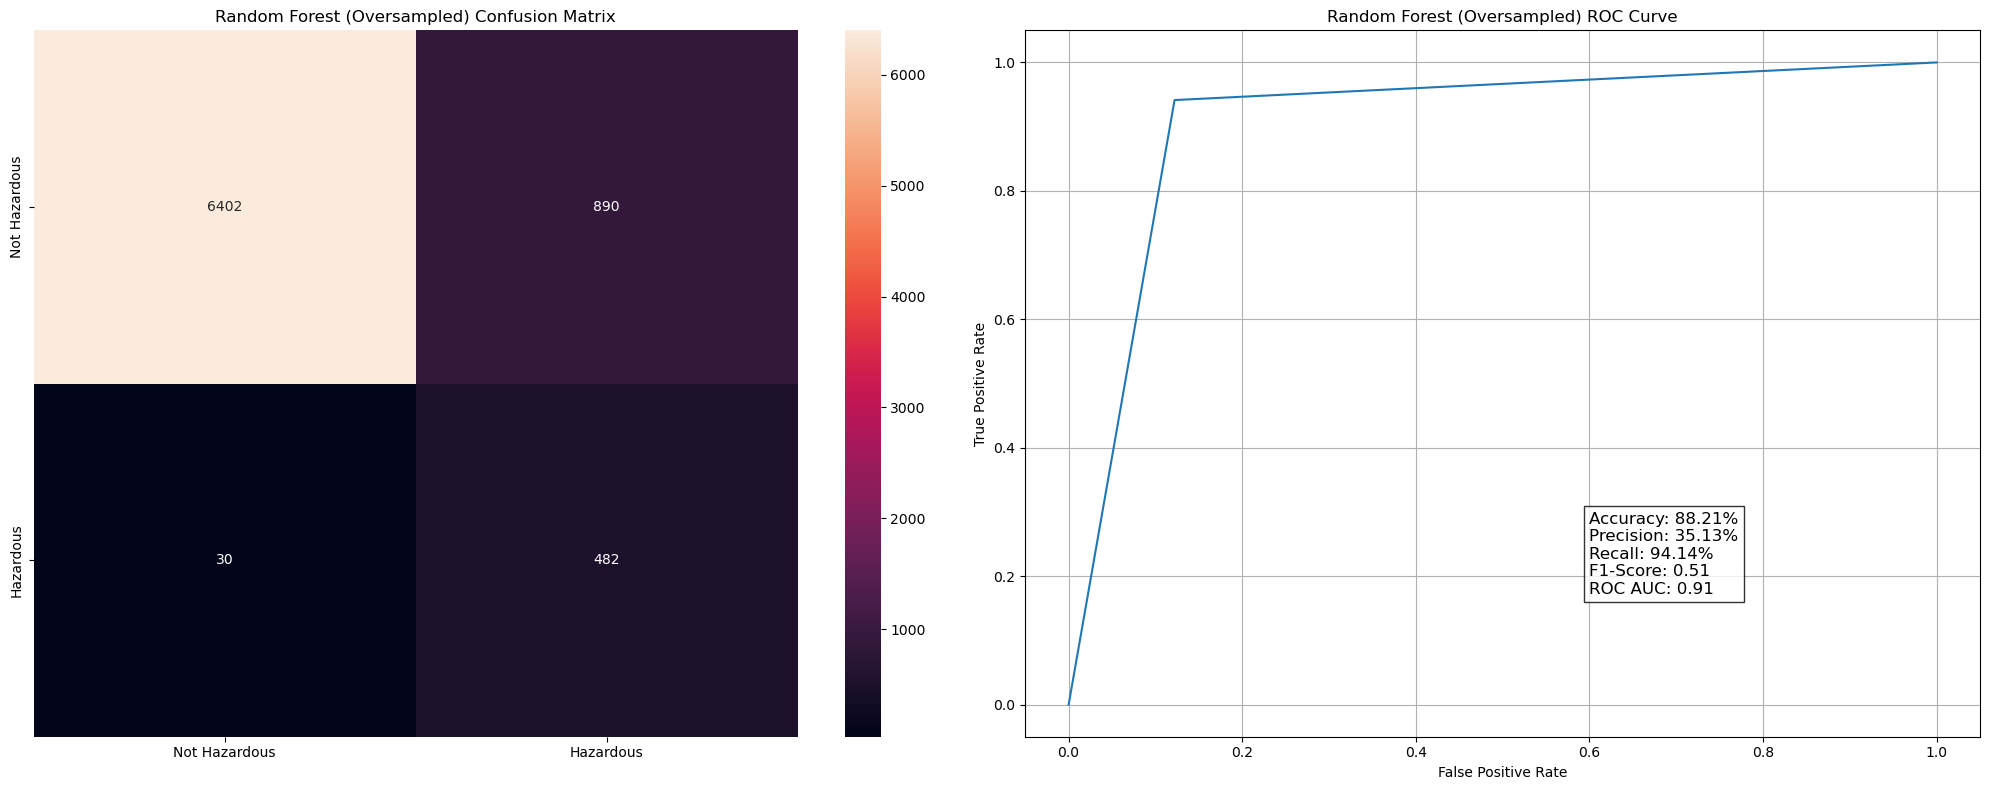

In [24]:
Y_pred = rfos_model.predict(X_test)
assess_model(Y_test, Y_pred, "Random Forest (Oversampled)", save_fig=True)

Despite lower accuracy and precision, this model has **excellent recall and ROC-AUC**, which is what matters most here.  
> It detects hazardous asteroids far more reliably than previous models.

## Gradient Boosted Classifier (Oversampled)

In [25]:
model = xgb.XGBClassifier(tree_method='hist', device='cpu', seed=42)
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

In [26]:
# tuner = XGBModelTuner(model, param_grid, X_res, Y_res)
# gbos_model = tuner.run(save_model=True, save_params=True, cv=skf, model_path="models/gradient_booster_os.json",
#                      param_path="params/gbos_params.json")
gbos_model = xgb.XGBClassifier()
gbos_model.load_model("models/gradient_booster_os.json")

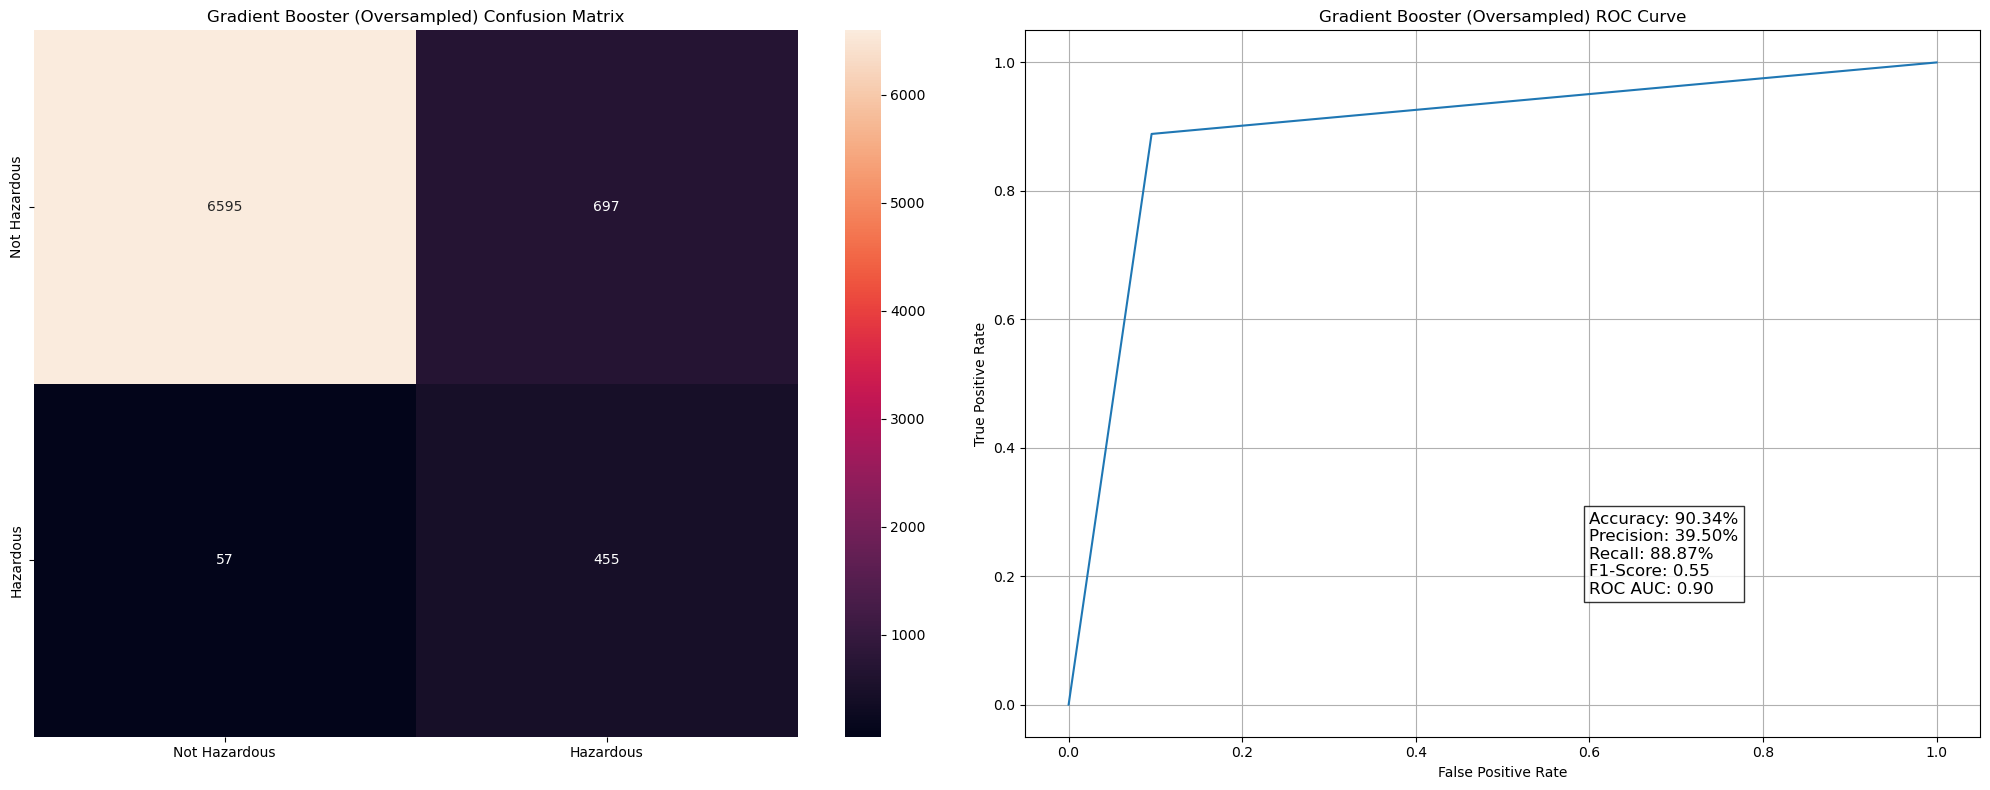

In [27]:
Y_pred = gbos_model.predict(X_test)
assess_model(Y_test, Y_pred, "Gradient Booster (Oversampled)", save_fig=True)

This model has better **accuracy and F1-score**, but slightly **lower recall and ROC-AUC** than the oversampled random forest.  
> It is **less effective at identifying hazardous asteroids**, which is not acceptable for this application.

# Conclusion

- **Oversampling significantly improves recall and ROC-AUC**, both critical for detecting hazardous asteroids.
- **Random Forest with SMOTE** offers the best balance of **hazardous asteroid detection** and **general model performance**.